<a href="https://colab.research.google.com/github/PisanoRaffaele/Lab_AI/blob/main/QuickDrawCNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Preambolo**


##Librerie

In [1]:
 !pip3 install wget
 !pip install --quiet pytorch-lightning>=1.5

In [2]:
import wget
import os
import numpy
import matplotlib.pyplot as pyplot
import random
from types import SimpleNamespace
from pathlib import Path
import math

# PyTorch Lightning
import torch
import torch.nn as nn
import torch.utils.data as data
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import pytorch_lightning as pl

# Torchvision
import torchvision
from torchvision import transforms
from torchvision import datasets

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Path e seed

I modelli gia addestrastri verranno salvati in questo path in modo da poterli riperndere se si sceglie di runnare con gli stessi samples e parametri.
Anche i dati .npy verranno salvati qui.

In [4]:
CHECKPOINT_PATH = "/content/drive/MyDrive/saved_models/"
DATA_PATH = "/content/drive/MyDrive/saved_models/"

# CHECKPOINT_PATH = "../saved_models/"
# DATA_PATH = "../saved_models/"

os.makedirs(CHECKPOINT_PATH, exist_ok=True)
os.makedirs(DATA_PATH, exist_ok=True)

Impostare il seed significa stabilire un valore iniziale per il generatore di numeri casuali. Questo consente di ottenere risultati riproducibili durante l'esecuzione di codice che coinvolge operazioni casuali.

In [5]:
def set_seed(seed):
    random.seed(seed)
    numpy.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)

    pl.seed_everything(seed)

set_seed(42)

INFO:lightning_fabric.utilities.seed:Global seed set to 42


Se disponibilie, usiamo il GPU

In [6]:
# garantisce il determinismo delle operazioni eseguite sulla GPU (se disponibile) in modo da ottenere risultati riproducibili.
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")

print(device)

cuda:0


## Dataset Download

###Download .npy

Prendiamo tutte le categorie del dataset salvate in https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/
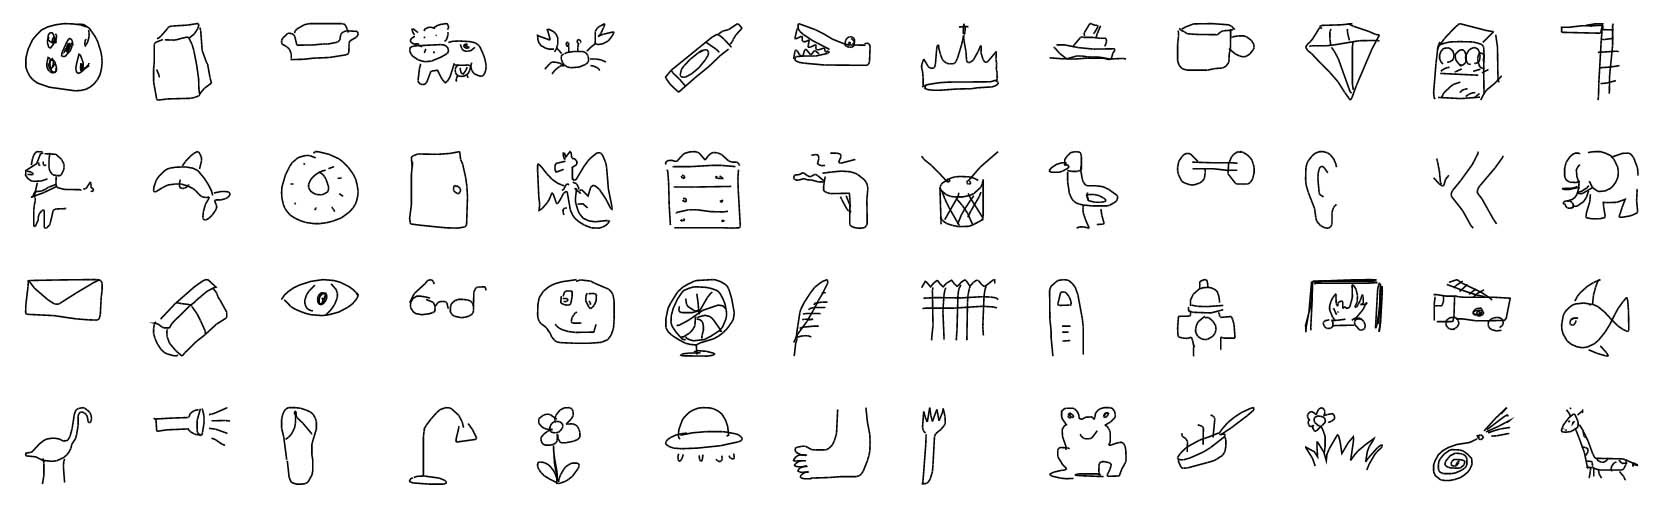

In [7]:
categories = [
     "aircraft carrier", "airplane", "alarm clock", "ambulance", "angel", "animal migration",
     "ant", "anvil", "apple", "arm", "asparagus", "axe", "backpack", "banana", "bandage", "barn",
     "baseball", "baseball bat", "basket", "basketball", "bat", "bathtub", "beach", "bear", "beard",
      "bed", "bee", "belt", "bench", "bicycle", "binoculars", "bird", "birthday cake", "blackberry",
      "blueberry", "book", "boomerang", "bottlecap", "bowtie", "bracelet", "brain", "bread", "bridge",
      "broccoli", "broom", "bucket", "bulldozer", "bus", "bush", "butterfly", "cactus", "cake",
      "calculator", "calendar", "camel", "camera", "camouflage", "campfire", "candle", "cannon",
      "canoe", "car", "carrot", "castle", "cat", "ceiling fan", "cello", "cell phone", "chair",
      "chandelier", "church", "circle", "clarinet", "clock", "cloud", "coffee cup", "compass",
      "computer", "cookie", "cooler", "couch", "cow", "crab", "crayon", "crocodile", "crown",
      "cruise ship", "cup", "diamond", "dishwasher", "diving board", "dog", "dolphin", "donut",
      "door", "dragon", "dresser", "drill", "drums", "duck", "dumbbell", "ear", "elbow", "elephant",
      "envelope", "eraser", "eye", "eyeglasses", "face", "fan", "feather", "fence", "finger",
      "fire hydrant", "fireplace", "firetruck", "fish", "flamingo", "flashlight", "flip flops",
      "floor lamp", "flower", "flying saucer", "foot", "fork", "frog", "frying pan", "garden",
      "garden hose", "giraffe", "goatee", "golf club", "grapes", "grass", "guitar", "hamburger",
      "hammer", "hand", "harp", "hat", "headphones", "hedgehog", "helicopter", "helmet", "hexagon",
       "hockey puck", "hockey stick", "horse", "hospital", "hot air balloon", "hot dog", "hot tub",
       "hourglass", "house", "house plant", "hurricane", "ice cream", "jacket", "jail", "kangaroo",
       "key", "keyboard", "knee", "knife", "ladder", "lantern", "laptop", "leaf", "leg", "light bulb",
       "lighter", "lighthouse", "lightning", "line", "lion", "lipstick", "lobster", "lollipop",
       "mailbox", "map", "marker", "matches", "megaphone", "mermaid", "microphone", "microwave",
       "monkey", "moon", "mosquito", "motorbike", "mountain", "mouse", "moustache", "mouth", "mug",
       "mushroom", "nail", "necklace", "nose", "ocean", "octagon", "octopus", "onion", "oven", "owl",
       "paintbrush", "paint can", "palm tree", "panda", "pants", "paper clip", "parachute", "parrot",
       "passport", "peanut", "pear", "peas", "pencil", "penguin", "piano", "pickup truck",
       "picture frame", "pig", "pillow", "pineapple", "pizza", "pliers", "police car", "pond", "pool",
       "popsicle", "postcard", "potato", "power outlet", "purse", "rabbit", "raccoon", "radio", "rain",
       "rainbow", "rake", "remote control", "rhinoceros", "rifle", "river", "roller coaster",
       "rollerskates", "sailboat", "sandwich", "saw", "saxophone", "school bus", "scissors", "scorpion",
       "screwdriver", "sea turtle", "see saw", "shark", "sheep", "shoe", "shorts", "shovel", "sink",
       "skateboard", "skull", "skyscraper", "sleeping bag", "smiley face", "snail", "snake", "snorkel",
       "snowflake", "snowman", "soccer ball", "sock", "speedboat", "spider", "spoon", "spreadsheet",
       "square", "squiggle", "squirrel", "stairs", "star", "steak", "stereo", "stethoscope", "stitches",
       "stop sign", "stove", "strawberry", "streetlight", "string bean", "submarine", "suitcase", "sun",
       "swan", "sweater", "swing set", "sword", "syringe", "table", "teapot", "teddy-bear", "telephone",
       "television", "tennis racquet", "tent", "The Eiffel Tower", "The Great Wall of China", "The Mona Lisa",
       "tiger", "toaster", "toe", "toilet", "tooth", "toothbrush", "toothpaste", "tornado", "tractor",
       "traffic light", "train", "tree", "triangle", "trombone", "truck", "trumpet", "t-shirt", "umbrella",
       "underwear", "van", "vase", "violin", "washing machine", "watermelon", "waterslide", "whale", "wheel",
       "windmill", "wine bottle", "wine glass", "wristwatch", "yoga", "zebra", "zigzag"
]

In [8]:
dataset_url = "https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/"

i = 1
for category in categories:
  if not os.path.exists(DATA_PATH + str(category) + ".npy"):
    category_url = dataset_url + str(category) + ".npy"
    wget.download(url = category_url, out = DATA_PATH)
    print(str(category) + " DWLD", end = " | ")
  else:
    print(str(category) + " OK", end = " | ")
  if (i % 16 == 0):
    print("")
  i += 1

# .npy array di dati numerici

aircraft carrier OK | airplane OK | alarm clock OK | ambulance OK | angel OK | animal migration OK | ant OK | anvil OK | apple OK | arm OK | asparagus OK | axe OK | backpack OK | banana OK | bandage OK | barn OK | 
baseball OK | baseball bat OK | basket OK | basketball OK | bat OK | bathtub OK | beach OK | bear OK | beard OK | bed OK | bee OK | belt OK | bench OK | bicycle OK | binoculars OK | bird OK | 
birthday cake OK | blackberry OK | blueberry OK | book OK | boomerang OK | bottlecap OK | bowtie OK | bracelet OK | brain OK | bread OK | bridge OK | broccoli OK | broom OK | bucket OK | bulldozer OK | bus OK | 
bush OK | butterfly OK | cactus OK | cake OK | calculator OK | calendar OK | camel OK | camera OK | camouflage OK | campfire OK | candle OK | cannon OK | canoe OK | car OK | carrot OK | castle OK | 
cat OK | ceiling fan OK | cello OK | cell phone OK | chair OK | chandelier OK | church OK | circle OK | clarinet OK | clock OK | cloud OK | coffee cup OK | compass OK | computer OK 

## Parametri principali addestramento

Alcuni parametri principaeli dell' addestramento:

In [9]:
batchSize = 64

trainingSamples = 200
testSamples = int(trainingSamples / 2)
valSamples = int(trainingSamples / 2)

epochs = 50

optimizerName = "SGD" # {Adam, SGD}
modelName = "ResNet" # {GoogleNet, ResNet}

actFnName = "relu" # { "tanh", "relu" }

#optimizerHparams
learningRate = 0.1 # {1e-3, 0.1}
weightDeacy = 1e-4 # {1e-4}

# la weight decay è un metodo per ridurre il valore dei pesi del modello durante
# l'aggiornamento dei pesi, allo scopo di penalizzare i pesi più grandi.

numCategories = len(categories)
TotSamples = (trainingSamples + testSamples + valSamples) * numCategories

foundPreTrained = False;

tp_count = [0] * numCategories
tn_count = [0] * numCategories
fn_count = [0] * numCategories
fp_count = [0] * numCategories

def print_params():
  print("Categories: " + str(numCategories))
  print("TotSamples: " + str(TotSamples))
  print("trainingSamples: " + str(trainingSamples))
  print("batchSize: " + str(batchSize))
  print("optimizerName: " + optimizerName)
  print("modelName: " + modelName)
  print("actFnName: " + actFnName)
  print("learningRate: " + str(learningRate))
  print("weightDeacy: " + str(weightDeacy))
  print("epochs: " + str(epochs))

## Dataset

###Heatmap

Per visualizzare una Heatmap delle varie classi fatta tramite una media

In [10]:
heatmapDictonary = {}

def get_label_heatmap(value):

    heatmap = numpy.mean(value, axis=0) # media

    return heatmap

In [11]:
def visualize_heatmaps():

  figure, axes = pyplot.subplots(35, 10, figsize=(15, 30))
  x = 0
  for key, value in heatmapDictonary.items():

    value = value[:784]
    value = value.reshape(1, 28, 28).astype("float32")
    value = (value - 127.5) / 127.5

    i = x // 10
    j = x % 10
    x += 1

    axes[i,j].set_title(key)
    axes[i,j].imshow(value.reshape(28, 28).squeeze())
    axes[i,j].axis('off')

  pyplot.subplots_adjust(hspace=0.9)
  pyplot.show()


###DataArray

Costruiamo a partire dai file .npy tre array di samples con dentro un numero uguale per ogni classe.
Ogni array servirà per uno scopo diverso:
- il trainDataset serve per addestrare il modello, cioè per insegnare al modello a riconoscere i modelli e le caratteristiche nelle immagini di input
- il testDataset è utilizzato per valutare le prestazioni del modello su dati non visti durante l'addestramento
- il valDataset è per regolare i parametri del modello e selezionare l'architettura migliore attraverso l'ottimizzazione dei parametri

In [12]:
i = 0;
for category in categories:
  startIndex = random.randint(0, 90000)
  samples = numpy.load(DATA_PATH + str(category) + ".npy", mmap_mode='r', allow_pickle=True)[startIndex : startIndex + TotSamples]

  value = samples.astype("float32")

  del samples

  if (i == 0):
    valueArray = numpy.c_[value, numpy.zeros(len(value))]
  else:
    valueArray = numpy.c_[value, i * numpy.ones(len(value))]

  del value

  numpy.random.shuffle(valueArray)

  heatmapDictonary[str(category)] = get_label_heatmap(valueArray)

  if (i == 0):
    numpytrainData = valueArray[:trainingSamples]
    numpytestData = valueArray[trainingSamples : trainingSamples + testSamples]
    numpyvalData = valueArray[trainingSamples + testSamples : trainingSamples + testSamples + valSamples]
  else:
    numpytrainData = numpy.concatenate((numpytrainData, valueArray[:trainingSamples]))
    numpytestData = numpy.concatenate((numpytestData, valueArray[trainingSamples : trainingSamples + testSamples]))
    numpyvalData = numpy.concatenate((numpyvalData, valueArray[trainingSamples + testSamples : trainingSamples + testSamples + valSamples]))
  i = i + 1
  del valueArray


In [13]:
#visualize_heatmaps()

###Visualize

per visualizzare qualche sample

In [14]:
def visualTrainingSet(x, y):
	figure, axes = pyplot.subplots(5, 10, figsize=(20, 10))

	for label in range(0, 50):

		randomLabel = numpy.random.randint(0, len(x) - 1)

		image = x[randomLabel].reshape((28, 28))
		title = categories[y[randomLabel]]

		xCordinate = label // 10

		yCordinate = label % 10

		axes[xCordinate, yCordinate].set_title(title)
		axes[xCordinate, yCordinate].imshow(image)
		axes[xCordinate, yCordinate].axis('off')

	pyplot.show()

###Training set

Nelle reti neurali, normalmente si vuole che i dati abbiano una media zero per diversi motivi:

***Miglioramento della convergenza:*** I dati con media zero aiutano nella convergenza più rapida dell'algoritmo di ottimizzazione durante l'addestramento della rete neurale. Se i dati hanno una media diversa da zero, potrebbe esserci uno sbilanciamento nelle attivazioni dei neuroni, che potrebbe portare a problemi di saturazione o addestramento più lento.

***Riduzione della dipendenza dalla scala:*** Quando i dati hanno media zero, i neuroni della rete non saranno dipendenti da una scala specifica.

***Stabilità numerica:*** L'uso di dati con media zero può contribuire a mantenere la stabilità numerica durante il calcolo all'interno della rete neurale. Potrebbe ridurre la probabilità di problemi come l'annullamento del gradiente o la saturazione delle funzioni di attivazione.

Passaggio dei dati e dei labels in tensori

In [15]:
trainX = numpytrainData[:, :784] # vengono estratte le prime 784 celle (28x28) (corrispondenti ai pixel delle immagini) e assegnate a trainX

trainY = numpytrainData[:, -1].astype("int") # viene estratta l'ultima colonna (corrispondente alle etichette delle immagini) e assegnata a trainY.

del numpytrainData

trainX = trainX.reshape(trainX.shape[0], 1, 28, 28).astype("float32")  #reshape in im 28x28

#trainX = (trainX - 127.5) / 127.5 #normalization it (to [-1,1])

#visualTrainingSet(trainX, trainY)

###Test set

In [16]:
testX = numpytestData[:, :784]
testY = numpytestData[:, -1].astype("int")

del numpytestData

testX = testX.reshape(testX.shape[0], 1, 28, 28).astype("float32")

#testX = (testX - 127.5) / 127.5

#visualTrainingSet(testX, testY)

###Validation set

In [17]:
valX = numpyvalData[:, :784]
valY = numpyvalData[:, -1].astype("int")

del numpyvalData

valX = valX.reshape(valX.shape[0],1, 28, 28).astype("float32")

#valX = (valX - 127.5) / 127.5

#visualTrainingSet(valX, valY)

###SetsCreation

sezione aggiunta dopo

In [18]:
trainX_tensor = torch.from_numpy(trainX).float()
trainY_tensor = torch.from_numpy(trainY).long()

del trainX
del trainY

In [19]:
testX_tensor = torch.from_numpy(testX).float()
testY_tensor = torch.from_numpy(testY).long()

del testX
del testY

In [20]:
valX_tensor = torch.from_numpy(valX).float()
valY_tensor = torch.from_numpy(valY).long()

del valX
del valY

creazione dei set effettivi

###Normalization

In [21]:
train_set = TensorDataset(trainX_tensor, trainY_tensor)
test_set = TensorDataset(testX_tensor, testY_tensor)
val_set = TensorDataset(valX_tensor, valY_tensor)

combined_tensor = torch.cat([train_set.tensors[0], test_set.tensors[0], val_set.tensors[0]], dim=0)

DATA_MEANS = (combined_tensor / 255.0).mean(axis=(0, 2, 3)).item()
DATA_STD = (combined_tensor / 255.0).std(axis=(0, 2, 3)).item()
print("Data mean", DATA_MEANS)
print("Data std", DATA_STD)

trainNormalized = (train_set.tensors[0] / 255.0 - DATA_MEANS) / DATA_STD
train_set = TensorDataset(trainNormalized, train_set.tensors[1])

testNormalized = (test_set.tensors[0] / 255.0 - DATA_MEANS) / DATA_STD
test_set = TensorDataset(testNormalized, test_set.tensors[1])

valNormalized = (val_set.tensors[0] / 255.0 - DATA_MEANS) / DATA_STD
val_set = TensorDataset(valNormalized, val_set.tensors[1])


del trainX_tensor
del trainY_tensor
del testX_tensor
del testY_tensor
del valX_tensor
del valY_tensor

Data mean 0.16880866885185242
Data std 0.32776758074760437


Creazione dei loader

In [22]:
train_loader = DataLoader(train_set, batch_size=batchSize, shuffle=True, drop_last=True, pin_memory=True, num_workers=2)
# shuffle=True: mischia i campioni ad ogni epoca
# drop_last=True: scarta l'ultimo batch se la dimensione del dataset non è un multiplo della dimensione del batch
# num_workers: processi separati per il caricamento dei dati in background, riducendo così il tempo di attesa per il caricamento dei dati

val_loader = DataLoader(val_set, batch_size=batchSize, shuffle=False, drop_last=False, num_workers=2)
test_loader = DataLoader(test_set, batch_size=batchSize, shuffle=False, drop_last=False, num_workers=2)

#**Modello**

##**LightningModule - Pytorch**

Il LightningModule è una classe fornita dalla libreria PyTorch Lightning che rappresenta il core del tuo modello di machine learning. È progettato per semplificare lo sviluppo di modelli PyTorch, fornendo una struttura organizzata e standardizzata per definire il modello, i passaggi di addestramento, le metriche e altre funzionalità associate.

In [23]:
import torchmetrics
from sklearn.metrics import precision_score, recall_score, f1_score

class QuickDrawModule(pl.LightningModule):

    def __init__(self, model_name, model_hparams, optimizer_name, optimizer_hparams):

        super().__init__()

        self.save_hyperparameters()

        self.model = get_model(model_name, model_hparams)

        self.loss_module = nn.CrossEntropyLoss()

        self.example_input_array = torch.zeros((1, 1, 28, 28), dtype=torch.float32)

    def forward(self, imgs):
        return self.model(imgs) # Riceve i dati di input, li passa attraverso il modello e restituisce le previsioni o le uscite del modello

    def configure_optimizers(self):
        if self.hparams.optimizer_name == "Adam":
            optimizer = optim.AdamW(self.parameters(), **self.hparams.optimizer_hparams)
        elif self.hparams.optimizer_name == "SGD":
            optimizer = optim.SGD(self.parameters(), **self.hparams.optimizer_hparams)
        else:
            assert False, f"Unknown optimizer: \"{self.hparams.optimizer_name}\""

        # scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[100, 150], gamma=0.1)
        # return [optimizer], [scheduler]

        scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', patience=5, factor=0.1, verbose=True)
        return {"optimizer": optimizer, "lr_scheduler": {"scheduler": scheduler, "monitor": "val_acc"}}

    def training_step(self, batch, batch_idx):
        imgs, labels = batch
        preds = self.model(imgs)
        loss = self.loss_module(preds, labels)
        acc = (preds.argmax(dim=-1) == labels).float().mean()
        self.log('train_acc', acc, on_step=False, on_epoch=True)
        self.log('train_loss', loss)
        return loss

    def validation_step(self, batch, batch_idx):
        imgs, labels = batch
        preds = self.model(imgs).argmax(dim=-1)
        acc = (labels == preds).float().mean()
        self.log('val_acc', acc)

    def test_step(self, batch, batch_idx):
        imgs, labels = batch
        preds = self.model(imgs).argmax(dim=-1)

        for class_idx in range(numCategories):
          not_class_mask2 = preds != class_idx
          not_class_labels2 = labels[not_class_mask2]

          not_class_mask = preds == class_idx
          not_class_preds = preds[not_class_mask]
          not_class_labels = labels[not_class_mask]

          class_mask = labels == class_idx
          class_preds = preds[class_mask]
          class_labels = labels[class_mask]

          tp_count[class_idx] += (class_labels == class_preds).sum().item()
          fn_count[class_idx] += (class_labels != class_preds).sum().item()
          fp_count[class_idx] += (not_class_labels != not_class_preds).sum().item()
          tn_count[class_idx] += (not_class_labels2 != class_idx).sum().item()

        acc = (labels == preds).float().mean()
        self.log('test_acc', acc, on_step=False, on_epoch=True)


##Metodi

La callback LearningRateMonitor aggiunge il tasso di apprendimento corrente a TensorBoard, il che aiuta a verificare che il nostro scheduler del tasso di apprendimento funzioni correttamente. La callback ModelCheckpoint consente di personalizzare la procedura di salvataggio dei checkpoint. Ad esempio, è possibile specificare quanti checkpoint mantenere, quando salvare, quale metrica considerare, ecc.

In [24]:
from pytorch_lightning.callbacks import LearningRateMonitor, ModelCheckpoint
from pytorch_lightning import Trainer

Per eventualmente runnare differenti modelli:

In [25]:
model_dict = {}

def get_model(model_name, model_hparams):
    if model_name in model_dict:
        return model_dict[model_name](**model_hparams)
    else:
        assert False, f"Unknown model name \"{model_name}\". Available models are: {str(model_dict.keys())}"

Dizionario di funzioni per il modello

In [26]:
fn_by_name = { "tanh": nn.Tanh, "relu": nn.ReLU, "leakyrelu": nn.LeakyReLU }

##Training

In [27]:
import shutil

def train_model(model_name, save_name=None, **kwargs):

    if save_name is None:
        save_name = model_name

    trainer = pl.Trainer(default_root_dir = os.path.join(CHECKPOINT_PATH, save_name),
                         accelerator="gpu" if str(device).startswith("cuda") else "cpu",
                         devices=1,                                                                          # Specifica il numero di GPU o CPU da utilizzare per l'addestramento
                         max_epochs=epochs,
                         callbacks=[ModelCheckpoint(save_weights_only=True, mode="max", monitor="val_acc"),   # Viene usata ModelCheckpoint: salva il miglior checkpoint in base alla val_acc massima
                                    LearningRateMonitor("epoch")],
                         enable_progress_bar=True)                                                             # e LearningRateMonitor per registrare il tasso di apprendimento ad ogni epoca.
    trainer.logger._log_graph = True                                                                         # viene generato il grafico di tensorboard.
    trainer.logger._default_hp_metric = False


    # verifica se c'è un modello preaddestrato
    versionfolderList = Path(os.path.join(CHECKPOINT_PATH, save_name, "lightning_logs/")).rglob("version_*")

    foundPreTrained = False

    for versionfolder in versionfolderList:
        CHECKPOINT_PATH_FILE = os.path.join(f"{versionfolder}/checkpoints/")
        checkpoint_files = list(Path(CHECKPOINT_PATH_FILE).rglob("finished.txt"))
        if (len(checkpoint_files) != 0):
            foundPreTrained = True;
            break;
        else:
            print(f"\nRemoving {versionfolder}... (old model not valid: incomplete training)\n")
            shutil.rmtree(versionfolder)

    if (foundPreTrained):
        pretrained_filename = list(Path(CHECKPOINT_PATH_FILE).rglob("*.ckpt"))[0]
    else:
        pretrained_filename = ""
        print("There is pretrained model: " + str(os.path.isfile(pretrained_filename)))

    if os.path.isfile(pretrained_filename):
        print(f"Found pretrained model at {pretrained_filename}, loading...")
        model = QuickDrawModule.load_from_checkpoint(pretrained_filename)
    else:
        model = QuickDrawModule(model_name=model_name, **kwargs)
        train_results = trainer.fit(model, train_loader, val_loader)
        model = QuickDrawModule.load_from_checkpoint(trainer.checkpoint_callback.best_model_path) # Load best checkpoint after training

    test_result = trainer.test(model, test_loader, verbose=False)
    val_result = trainer.test(model, val_loader, verbose=False)
    result = {"test_acc": test_result[0]["test_acc"], "val_acc": val_result[0]["test_acc"]}

    logs = trainer.logged_metrics
    return model, result, logs

## **GoogleNet**

Batch Normalization:

utilizzata in entrambi i moduli, l'obiettivo della Batch Normalization è normalizzare l'output di ogni livello di una rete neurale in modo che abbia una media zero e una deviazione standard unitaria. Questo viene fatto normalizzando i dati all'interno di mini-batch, ovvero gruppi di esempi di addestramento che vengono processati insieme.



###Inception Module


Indicate le dimensione dei kernel dei filtri

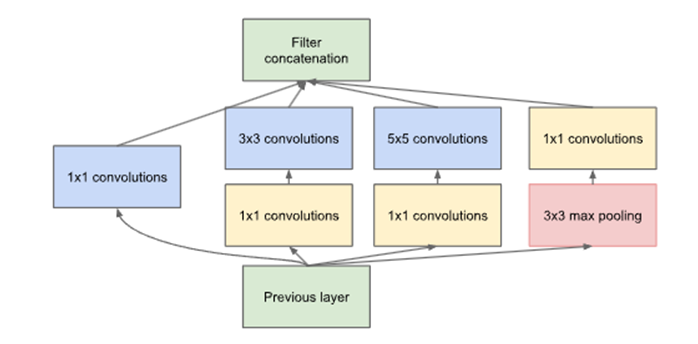

Max polling:

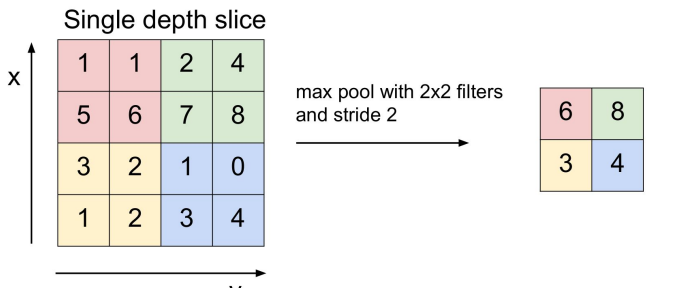

In [28]:
class InceptionBlock(nn.Module):

    def __init__(self, c_in, c_red : dict, c_out : dict, act_fn):

            # c_in - numero delle features di input derivante dal layer precedente
            # c_red - Dizionario con chiavi "3x3" and "5x5" che specifica l'output delle convoluzioni 1x1
            # c_out -Dizionario con chiavi "1x1", "3x3", "5x5", and "max" per le dimensioni di output
            # act_fn - Funzione di attivazione

        super().__init__()

        # 1x1 convolution branch: catturare le informazioni locali dell'input. Aiuta ad estrarre le caratteristiche di basso livello.
        self.conv_1x1 = nn.Sequential(
            nn.Conv2d(c_in, c_out["1x1"], kernel_size=1),
            nn.BatchNorm2d(c_out["1x1"]), # normalizzare l'output di ogni livello di una rete neurale in modo che abbia una media zero e una deviazione standard unitaria.
            act_fn()
        )

        # 3x3 convolution branch: Aiuta a catturare dettagli più grandi nell'immagine.
        self.conv_3x3 = nn.Sequential(
            nn.Conv2d(c_in, c_red["3x3"], kernel_size=1),
            nn.BatchNorm2d(c_red["3x3"]),
            act_fn(),
            nn.Conv2d(c_red["3x3"], c_out["3x3"], kernel_size=3, padding=1), # aggiunge pixel di zero padding su ogni lato dell'input
            nn.BatchNorm2d(c_out["3x3"]),
            act_fn()
        )

        # 5x5 convolution branch: Aiuta a catturare ulteriori dettagli di scala ancora più grande.
        self.conv_5x5 = nn.Sequential(
            nn.Conv2d(c_in, c_red["5x5"], kernel_size=1),
            nn.BatchNorm2d(c_red["5x5"]),
            act_fn(),
            nn.Conv2d(c_red["5x5"], c_out["5x5"], kernel_size=5, padding=2),
            nn.BatchNorm2d(c_out["5x5"]),
            act_fn()
        )

        # Max-pool branch: riduce la dimensione dell'input e cattura le caratteristiche più dominanti.
        self.max_pool = nn.Sequential(
            nn.MaxPool2d(kernel_size=3, padding=1, stride=1),
            nn.Conv2d(c_in, c_out["max"], kernel_size=1),
            nn.BatchNorm2d(c_out["max"]),
            act_fn()
        )

    def forward(self, x):
        x_1x1 = self.conv_1x1(x)
        x_3x3 = self.conv_3x3(x)
        x_5x5 = self.conv_5x5(x)
        x_max = self.max_pool(x)
        x_out = torch.cat([x_1x1, x_3x3, x_5x5, x_max], dim=1)
        return x_out

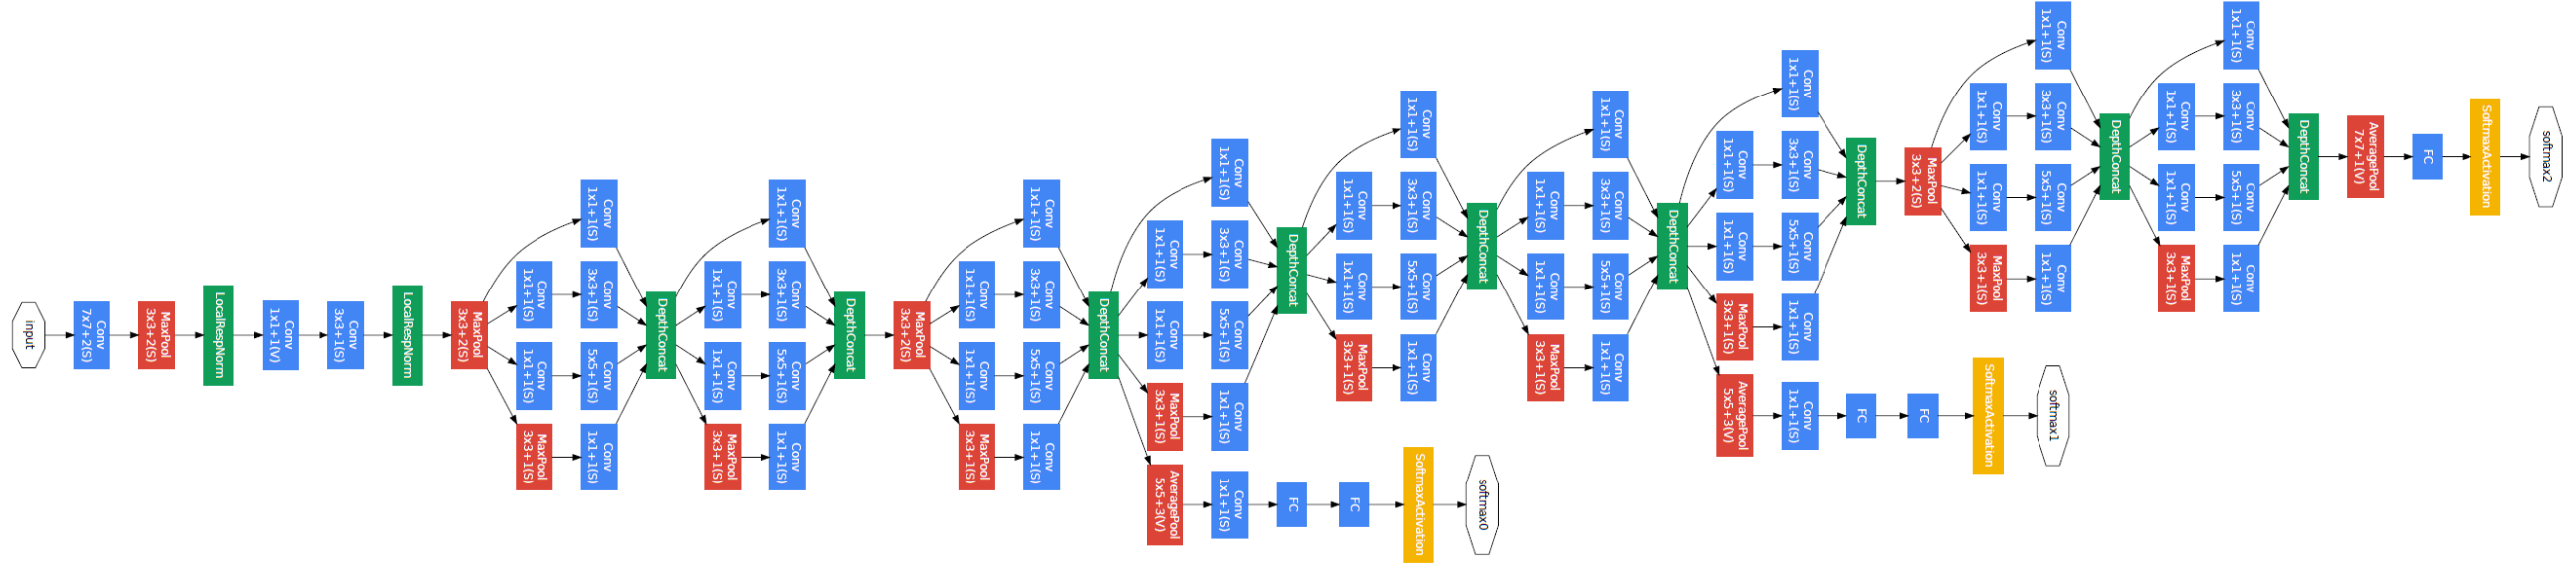

In [29]:
class GoogleNet(nn.Module):

    def __init__(self, num_classes=numCategories, act_fn_name=actFnName, **kwargs):
        super().__init__()
        self.hparams = SimpleNamespace(num_classes=num_classes,
                                       act_fn_name=act_fn_name,
                                       act_fn=fn_by_name[act_fn_name])
        self._create_network()
        self._init_params()

    def _create_network(self):
        # A first convolution on the original image to scale up the channel size
        self.input_net = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=3, padding=1), # 1: canali di input, l'immagine è in scale di grigi; 64: canali di output
            nn.BatchNorm2d(64),
            self.hparams.act_fn()
        )
        # Stacking inception blocks
        self.inception_blocks = nn.Sequential(
            InceptionBlock(64, c_red={"3x3": 32, "5x5": 16}, c_out={"1x1": 16, "3x3": 32, "5x5": 8, "max": 8}, act_fn=self.hparams.act_fn),
            InceptionBlock(64, c_red={"3x3": 32, "5x5": 16}, c_out={"1x1": 24, "3x3": 48, "5x5": 12, "max": 12}, act_fn=self.hparams.act_fn),
            nn.MaxPool2d(3, stride=2, padding=1),
            InceptionBlock(96, c_red={"3x3": 32, "5x5": 16}, c_out={"1x1": 24, "3x3": 48, "5x5": 12, "max": 12}, act_fn=self.hparams.act_fn),
            InceptionBlock(96, c_red={"3x3": 32, "5x5": 16}, c_out={"1x1": 16, "3x3": 48, "5x5": 16, "max": 16}, act_fn=self.hparams.act_fn),
            InceptionBlock(96, c_red={"3x3": 32, "5x5": 16}, c_out={"1x1": 16, "3x3": 48, "5x5": 16, "max": 16}, act_fn=self.hparams.act_fn),
            InceptionBlock(96, c_red={"3x3": 32, "5x5": 16}, c_out={"1x1": 32, "3x3": 48, "5x5": 24, "max": 24}, act_fn=self.hparams.act_fn),
            nn.MaxPool2d(3, stride=2, padding=1),  # 16x16 => 8x8
            InceptionBlock(128, c_red={"3x3": 48, "5x5": 16}, c_out={"1x1": 32, "3x3": 64, "5x5": 16, "max": 16}, act_fn=self.hparams.act_fn),
            InceptionBlock(128, c_red={"3x3": 48, "5x5": 16}, c_out={"1x1": 32, "3x3": 64, "5x5": 16, "max": 16}, act_fn=self.hparams.act_fn)
        )
        # Mapping to classification output
        self.output_net = nn.Sequential(
            nn.AdaptiveAvgPool2d((1, 1)), # riduce le dimensioni spaziali dell'input a una dimensione fissa.
            nn.Flatten(), # Questa operazione serve a "appiattire" l'output del pooling adattivo in un vettore unidimensionale.
            nn.Linear(128, self.hparams.num_classes)
        )

    def _init_params(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(
                    m.weight, nonlinearity=self.hparams.act_fn_name)  #inizializza i pesi di tutti i moduli interni
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
        x = self.input_net(x)
        x = self.inception_blocks(x)
        x = self.output_net(x)
        return x

model_dict["GoogleNet"] = GoogleNet

##**ResNet**

La ResNet introduce l'idea di skip connection o connessioni residue per affrontare il problema della scomparsa del gradiente. Queste connessioni residue consentono al flusso del gradiente di bypassare uno o più strati, saltando direttamente a strati successivi. Questo passaggio diretto del gradiente consente di evitare la scomparsa del gradiente e di consentire un'apprendimento più efficace.

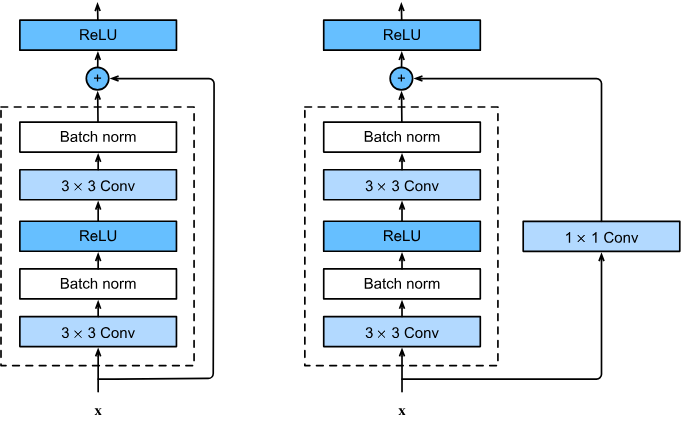

In [30]:
class ResNetBlock(nn.Module):

    def __init__(self, c_in, act_fn, subsample=False, c_out=-1):

            # subsample - se è True applichiamo una stride di 2 riducendo la dimensione di output
            # c_out - Rilevante solo subsample è True, altrimenti, c_out = c_in

        super().__init__()
        if not subsample:
            c_out = c_in

        self.net = nn.Sequential(
            nn.Conv2d(c_in, c_out, kernel_size=3, padding=1, stride=1 if not subsample else 2, bias=False),  # bias= False la Batch Normalization si occupa di gestirlo internamente
            nn.BatchNorm2d(c_out),
            act_fn(),
            nn.Conv2d(c_out, c_out, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(c_out)
        )

        self.downsample = nn.Conv2d(c_in, c_out, kernel_size=1, stride=2) if subsample else None
        self.act_fn = act_fn()

    def forward(self, x):
        z = self.net(x)
        if self.downsample is not None:
            x = self.downsample(x)
        out = z + x
        out = self.act_fn(out)
        return out

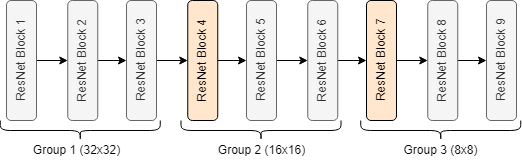

In [31]:
resnet_blocks_by_name = {
    "ResNetBlock": ResNetBlock
}

In [32]:
class ResNet(nn.Module):

    def __init__(self, num_classes=numCategories, num_blocks=[3,3,3], c_hidden=[16,32,64], act_fn_name="relu", block_name="ResNetBlock", **kwargs):

            # num_blocks - Lista del numero di Blocchi da usare per ogni gruppo. Il primo di ogni gruppo usa downsampling, tranne il primo.
            # c_hidden - dimensioni interne

        super().__init__()
        assert block_name in resnet_blocks_by_name
        self.hparams = SimpleNamespace(num_classes=num_classes,
                                       c_hidden=c_hidden,
                                       num_blocks=num_blocks,
                                       act_fn_name=act_fn_name,
                                       act_fn=fn_by_name[act_fn_name],
                                       block_class=resnet_blocks_by_name[block_name])
        self._create_network()
        self._init_params()

    def _create_network(self):
        c_hidden = self.hparams.c_hidden

        # una prima convouluzione per scalare la dimesnione a c_hidden[0]

        self.input_net = nn.Sequential(
            nn.Conv2d(1, c_hidden[0], kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(c_hidden[0]),
            self.hparams.act_fn()
        )

        # Creazione dei ResNet Blocks
        blocks = []
        for block_idx, block_count in enumerate(self.hparams.num_blocks):
            for bc in range(block_count):
                subsample = (bc == 0 and block_idx > 0) # Subsample the first block of each group, except the very first one.
                blocks.append(
                    self.hparams.block_class(c_in=c_hidden[block_idx if not subsample else (block_idx-1)],
                                             act_fn=self.hparams.act_fn,
                                             subsample=subsample,
                                             c_out=c_hidden[block_idx])
                )
        self.blocks = nn.Sequential(*blocks)

        # output
        self.output_net = nn.Sequential(
            nn.AdaptiveAvgPool2d((1,1)),
            nn.Flatten(),
            nn.Linear(c_hidden[-1], self.hparams.num_classes)
        )

    def _init_params(self): # inizializza i pesi di tutti i moduli interni
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity=self.hparams.act_fn_name)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
        x = self.input_net(x)
        x = self.blocks(x)
        x = self.output_net(x)
        return x

In [33]:
model_dict["ResNet"] = ResNet

##**Training**

In [ ]:
NomeModello=f"{modelName}_{numCategories}classes_{TotSamples}samples"

optimizerHparams = {"lr": learningRate, "weight_decay": weightDeacy}

# il momentum può aiutare con i minimi locali e "selle"
if optimizerName == "SGD":
  optimizerHparams = {"lr": learningRate, "momentum": 0.9, "weight_decay": weightDeacy}



trained_model, results, logs = train_model(model_name = modelName,
                                                 save_name = NomeModello,
                                                 model_hparams={"num_classes": numCategories,
                                                                "act_fn_name": actFnName},
                                                 optimizer_name = optimizerName,
                                                 optimizer_hparams = optimizerHparams)


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


There is pretrained model: False


INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name        | Type             | Params | In sizes       | Out sizes
------------------------------------------------------------------------------
0 | model       | ResNet           | 293 K  | [1, 1, 28, 28] | [1, 345] 
1 | loss_module | CrossEntropyLoss | 0      | ?              | ?        
------------------------------------------------------------------------------
293 K     Trainable params
0         Non-trainable params
293 K     Total params
1.175     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

In [ ]:
directory = os.path.join(CHECKPOINT_PATH, NomeModello, "lightning_logs/version_0/checkpoints")

percorso_file = os.path.join(directory, "finished.txt")


with open(percorso_file, "w+") as file:
  if (not foundPreTrained):
    file.write(".")

##**Results**

In [ ]:
dir_tensorboard = os.path.join(CHECKPOINT_PATH, NomeModello, "lightning_logs/version_0")

# Load tensorboard extension
%load_ext tensorboard

# Opens tensorboard in notebook.
%tensorboard --logdir $dir_tensorboard --port=800

In [ ]:
print_params()

In [ ]:
print(f"{modelName} Results", results)

In [ ]:
print('Accuracy:')
for i, category in enumerate(categories):
  print(str(category) + ' [acc]: ' + str( (tp_count[i] + tn_count[i]) / (tp_count[i] + tn_count[i] + fp_count[i] + fn_count[i])))
print('\n')

print('PPV, Precision')
for i, category in enumerate(categories):
  print(str(category) + ' [PPV]: ' + str(tp_count[i] / (tp_count[i] + fp_count[i])))
print('\n')

print('TPR, True Positive Rate, Recall')
for i, category in enumerate(categories):
  print(str(category) + ' [TPR]: ' + str(tp_count[i] / (tp_count[i] + fn_count[i])))
print('\n')

print('F1-Score')
for i, category in enumerate(categories):
  P = tp_count[i] / (tp_count[i] + fp_count[i])
  R = tp_count[i] / (tp_count[i] + fn_count[i])
  print(str(category) + ' [F1]: ' + str( 2 * P * R / (P + R) ))
print('\n')

print('FPR, False Positive Rate')
for i, category in enumerate(categories):
  print(str(category) + ' [FPR]: ' + str(fp_count[i] / (fp_count[i] + tn_count[i])))
print('\n')

#**Concluisioni**

In [ ]:
url = "https://github.com/PisanoRaffaele/Lab_AI"
!git clone $url repo
RESULTS_PATH = "repo/results"
%load_ext tensorboard

##**Scelta del modello**

La scelta del modello ottimale per risolvere questo problema di classificazione di tutte le 345 classi del 'QuickDrawDataset' è partito dalla scelta delle CNN [GoogleNet](https://arxiv.org/abs/1409.4842) e della [ResNet](https://arxiv.org/abs/1512.03385) come 'state of art'.

Prese l'implementazioni delle CNN è stato necessario adattarle al formato del dataset da analizzare (1x28x28).
Dopodiché è avvenuto un primo addestramento di entrambe le reti con i paramteri presi anche questi come 'state of art' dall' implementazione precedente dei modelli stessi.

Di seguito i risultati:

###***GoogleNet con parametri:***
* modelName: GoogleNet
* actFnName: relu
* Categories: 345
* TotSamples: 138000
* trainingSamples: 200
* testSamples: 100
* validationSamples: 100
* batchSize: 64
* epochs: 150
* optimizerName: Adam
* learningRate: 0.001 { optimazer param }
* weightDeacy: 0.0001 { optimazer param }


results: {'test_acc': 0.5655652284622192, 'val_acc': 0.5659710168838501}

In [ ]:
dir_tensorboard = os.path.join(RESULTS_PATH, "GoogleNet/Adam_base")

%tensorboard --logdir $dir_tensorboard --port=8001

Durante le prime epoche la validation accuracy cresce fino ad arrivare al punto di addestramento più 'accurato' che viene salvato tramite i checkpoint e usato poi per il test che da risultato di {test_acc = 0.5655}. (all' epoca 11)

Il modello va ben presto però in overfitting e la val_acc decresce nelle epoche successive, questo dovuto alla elevata complessità della GoogleNet e alla scarsità di samples presi in input per ogni classe:
la rete infatti impara il rumore di quei samples.

Proprio a causa della elevata complessità della rete stessa e a causa della limitata disponibilità computazionale l'addestramento ha richiesto molto tempo ed è impossibile alzare significativamente il livello di samples per ogni classe.

Inoltre si può notaree che dall' epoca 100 c'è un aumento imporvviso della val_acc dovuto alla 'scalatura' di 0.1 del learning_rate dell'ottimizzatore.
Il codice che lo implementava era questo:  

```
scheduler = MultiStepLR(optimizer, milestones=[100, 150], gamma=0.1)
```

Poi successivamente sostituito con un meccanismo piu efficiente per l'abbassamento del lr con risultati piu soddisfacenti


###***ResNet con parametri:***

* modelName: ResNet
* actFnName: relu
* Categories: 345
* TotSamples: 138000
* trainingSamples: 200
* testSamples: 100
* validationSamples: 100
* batchSize: 64
* epochs: 150
* optimizerName: SGD
* learningRate: 0.1 { optimazer param }
* weightDeacy: 0.0001 { optimazer param }

results: {'test_acc': 0.582753598690033, 'val_acc': 0.5789275169372559}


In [ ]:
dir_tensorboard = os.path.join(RESULTS_PATH, "ResNet/SGD_Base")

%tensorboard --logdir $dir_tensorboard --port=6002

Questo modello porta invece a risultati piu soddisfacenti in quanto la test_acc è piu elevata, risponde meglio all'abbassamento del learning rate dalla 100 esima epoca in poi ed infine richiede meno tempo per l'addestramento stesso.

Richiedendo meno tempo sarà anche possibile aumentare il numero di samples per il training in modo da miglirare le prestazioni.

Dalla Loss si puo notare facilmente che nella prima parte il learning rate è troppo alto, mentre nella seconda probabilmete basso, con un passaggio troppo netto

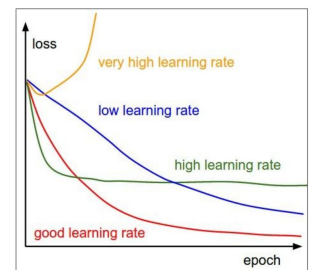

###***Modifica dell' andamento del learning rate***

Per migliorare le prestazioni e fare un ulteriore confronto è stato modificato l'andamento del learning rate scalandolo di 0.1 ogni 5 epoche con train_acc discendente.

`scheduler = ReduceLROnPlateau(optimizer, mode='max', patience=5, factor=0.1, verbose=True)`

`return {"optimizer": optimizer, "lr_scheduler": {"scheduler": scheduler, "monitor": "val_acc"}}
`

Questo ha permesso di aumentare l'apprendimento proprio nel momento piu vicino possibile al 'massimo locale' della train_acc. Inoltre ha dato modo di ridurre il numero di epoche al minimo necessario e di conseguenza di aumentare il numero di samples avendo più tempo a disposizione per ogni epoca e piu potere 'computazionale' (limitato su colab).

Si ripetono i testi sui due modelli per il confronto:

####***GoogleNet con nuovo lr***

* modelName: GoogleNet
* actFnName: relu
* Categories: 345
* TotSamples: 138000
* trainingSamples: 200
* testSamples: 100
* validationSamples: 100
* batchSize: 64
* epochs: 50
* optimizerName: Adam
* learningRate: 0.001 { optimazer param }
* weightDeacy: 0.0001 { optimazer param }

results: {'test_acc': 0.585159420967102, 'val_acc': 0.5911014676094055}

In [ ]:
dir_tensorboard = os.path.join(RESULTS_PATH, "GoogleNet/Adam_base_newoptim")

%tensorboard --logdir $dir_tensorboard --port=6003

####***ResNet con nuovo lr***

* modelName: ResNet
* actFnName: relu
* Categories: 345
* TotSamples: 138000
* trainingSamples: 200
* testSamples: 100
* validationSamples: 100
* batchSize: 64
* epochs: 150
* optimizerName: SGD
* learningRate: 0.1 { optimazer param }
* weightDeacy: 0.0001 { optimazer param }

results: {'test_acc': 0.5940290093421936, 'val_acc': 0.5937970876693726}


In [ ]:
dir_tensorboard = os.path.join(RESULTS_PATH, "ResNet/SGD_Base_newoptim")

%tensorboard --logdir $dir_tensorboard --port=6005

La modifica riporta risultati positivi in entrambi i casi con la conferma che il modello con ResNet ottiene risultati leggermente migliori.

In definitiva si è proseguito cercando di migliorare tale modello.

##***Scelta dei parametri***

Per testare l'ottimizzatore Adam anche su questo modello si è eseguito un test sullo 'state of art' originale del modello sostituendo l'optimizer e cambiando il relativo lr.

###***ResNet Adam***


* modelName: ResNet
* actFnName: relu
* Categories: 345
* TotSamples: 138000
* trainingSamples: 200
* testSamples: 100
* validationSamples: 100
* batchSize: 64
* epochs: 150
* optimizerName: Adam
* learningRate: 0.001 { optimazer param }
* weightDeacy: 0.0001 { optimazer param }

results: {'test_acc': 0.5422898530960083, 'val_acc': 0.5411304235458374}

In [ ]:
dir_tensorboard = os.path.join(RESULTS_PATH, "ResNet/Adam_Base")

%tensorboard --logdir $dir_tensorboard --port=6006

La più bassa test_acc conferma l'utilizzo dell'ottimizzatore SGD.

L'SGD con un adeguato 'tuning' del LR ha migliori prestazioni rispetto all'ottimizzatore Adam

###***ResNet 800***

* modelName: ResNet
* actFnName: relu
* Categories: 345
* TotSamples: 414000
* trainingSamples: 800
* testSamples: 200
* validationSamples: 200
* batchSize: 64
* epochs: 70
* optimizerName: SGD
* learningRate: 0.1 { optimazer param }
* weightDeacy: 0.0001 { optimazer param }

ResNet Results {'test_acc': 0.6761594414710999, 'val_acc': 0.6761594414710999}

Per sfruttare la potenza di calcolo guadagnata riducendo le epoche ed usando il modello meno 'complesso' si decide di eseguire il modello modificato fino a questo momento con 800 samples per ogni classe.
Inoltre il numero di test_samples e val_samples è stato dimezzato proprio per favorire l'aumento del numero di test_samples.

Tutto questo ha portato ad un significativo aumento della test_acc

In [ ]:
dir_tensorboard = os.path.join(RESULTS_PATH, "ResNet/SGD_800_no")

%tensorboard --logdir $dir_tensorboard --port=6007

Si prosegue con il test dello stesso modello ma con le proporzioni dei training, validation, test samples differenti: (uguali allo 'state of art') 50% 25% 25%.

###***ResNet 800 50/25/25***

* modelName: ResNet
* actFnName: relu
* Categories: 345
* TotSamples: 552000
* trainingSamples: 800
* testSamples: 400
* validationSamples: 400
* batchSize: 64
* epochs: 40
* optimizerName: SGD
* learningRate: 0.1 { optimazer param }
* weightDeacy: 0.0001 { optimazer param }

ResNet Results {'test_acc': 0.6724275350570679, 'val_acc': 0.6726232171058655}

Riporta un risultato peggiore: si lascierà 2/3, 1/6, 1/6

###***Batch Size***

Si procede con il test con il passaggio prima a 32 e poi a 128 di batch size per verificare se il cambio del numero di esempi di addestramento utilizzati in ogni iterazione porta a miglioramento.

####***ResNet 800 Batch 32***

* modelName: ResNet
* actFnName: relu
* Categories: 345
* TotSamples: 414000
* trainingSamples: 800
* testSamples: 200
* validationSamples: 200
* batchSize: 32
* epochs: 42
* optimizerName: SGD
* learningRate: 0.1 { optimazer param }
* weightDeacy: 0.0001 { optimazer param }

ResNet Results {'test_acc': 0.6735362410545349, 'val_acc': 0.6744927763938904}

####***ResNet 800 Batch 128***

* modelName: ResNet
* actFnName: relu
* Categories: 345
* TotSamples: 414000
* trainingSamples: 800
* testSamples: 200
* validationSamples: 200
* batchSize: 128
* epochs: 42
* optimizerName: SGD
* learningRate: 0.1 { optimazer param }
* weightDeacy: 0.0001 { optimazer param }

ResNet Results {'test_acc': 0.6726086735725403, 'val_acc': 0.6698405742645264}

Nessuno dei due migliora le prestazioni

###***ResNet 800 tanh***

* modelName: ResNet
* actFnName: tanh
* Categories: 345
* TotSamples: 414000
* trainingSamples: 800
* testSamples: 200
* validationSamples: 200
* batchSize: 64
* epochs: 55
* optimizerName: SGD
* learningRate: 0.1 { optimazer param }
* weightDeacy: 0.0001 { optimazer param }

ResNet Results {'test_acc': 0.6504927277565002, 'val_acc': 0.6488260626792908}

In generale la tanh e la sigmoid non sono consigliate perchè 'uccidono' il gradiente quando si trovano nella zona di saturazione e quindi non c'è correzzione dei pesi

mentre la leakyrelu non può essere utilizzata perchè il Kaiming normal initialization method non la supporta. (è utilizzato per inizializzare i pesi nelle rete neurale). Questo metodo tiene conto della funzione di nonlinearità utilizzata nella rete per regolare la scala dei pesi inizializzati.

Quindi anche cambiando la funzione di attivazione i risultati peggiorano.

In [ ]:
dir_tensorboard = os.path.join(RESULTS_PATH, "ResNet/SGD_800_no_tanh/version_0")

%tensorboard --logdir $dir_tensorboard --port=6009

#***Diversa normalizzazione:***

invece di (im - 127.5)/127.5
im = (im - imgs.mean()) / imgs.std()

##***ResNet 200 con nuova normalizzazione***

* modelName: ResNet
* actFnName: relu
* Categories: 345
* TotSamples: 138000
* trainingSamples: 200
* testSamples: 100
* validationSamples: 100
* batchSize: 64
* epochs: 50
* optimizerName: SGD
* learningRate: 0.1 { optimazer param }
* weightDeacy: 0.0001 { optimazer param }

Results: {'test_acc': 0.5933043360710144, 'val_acc': 0.5923478007316589}


poca differenza anche perchè le imm sono normalizzate quasi ad ogni layer convoluzionale

##***Conclusione***

Quello della ResNet 800 risulta essere il modello piu preciso con una test_acc del  67.61594414710999 %